In [57]:
import pandas as pd
import numpy as np
import copy, re, time
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# 讀取訓練與測試資料
data_path = '/Users/gary/data_marathon/Part02/'
df_train = pd.read_csv(data_path + 'titanic_train.csv')
df_test = pd.read_csv(data_path + 'titanic_test.csv')

# 訓練資料需要 train_X, train_Y / 預測輸出需要 ids(識別每個預測值), test_X
# 先抽離出 train_Y 與 ids
train_Y = df_train['Survived']
ids = df_test['PassengerId']
train_num = train_Y.shape[0]

# 將 train_X, test_X 該有的資料合併成 df, 作特徵工程
df_train = df_train.drop(['PassengerId', 'Survived'] , axis=1)
df_test = df_test.drop(['PassengerId'] , axis=1)
df = pd.concat([df_train,df_test])

In [106]:
train_num

891

In [8]:
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [106]:
df.shape

(1309, 10)

In [53]:
# 檢查欄位缺值數量
df.isnull().sum()[lambda x:x>0].sort_values(ascending=False)

Cabin       1014
Age          263
Embarked       2
Fare           1
dtype: int64

In [10]:
# 分開處理類別/數值欄位
object_features = list(df.select_dtypes(include=["object"]).columns)
numeric_features = list(df.select_dtypes(exclude=["object"]).columns)

# Object

In [11]:
df_object = df[object_features]
df_object.head()

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


In [12]:
for i in df_object.columns:
    print(i, len(pd.Series(df_object[i]).unique()))

Name 1307
Sex 2
Ticket 929
Cabin 187
Embarked 4


In [14]:
df_object['Family_Name'] = df_object['Name'].apply(lambda x:x.split(',')[0])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
name = df_object['Name']
name[~name.str.contains('Mr.|Mrs.|Ms.|Miss.|Master.|Rev.|Dr.|Col.', regex=True)]

30                              Uruchurtu, Don. Manuel E
369                        Aubart, Mme. Leontine Pauline
449                       Peuchen, Major. Arthur Godfrey
536                    Butt, Major. Archibald Willingham
641                                 Sagesser, Mlle. Emma
745                         Crosby, Capt. Edward Gifford
759    Rothes, the Countess. of (Lucy Noel Martha Dye...
822                      Reuchlin, Jonkheer. John George
414                         Oliva y Ocana, Dona. Fermina
Name: Name, dtype: object

In [15]:
def title(x):
    options = ['Mr.','Mrs.','Ms.','Miss.','Master.','Rev.','Dr.','Col.']
    for i in options:
        if i in x:
            return i
    return 'Else'

In [16]:
df_object['Title'] = df_object['Name'].apply(title)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [121]:
df_object[df_object['Title']=='Else']

,Name,Sex,Ticket,Cabin,Embarked,Title
30,"Uruchurtu, Don. Manuel E",male,PC 17601,NaN,C,Else
369,"Aubart, Mme. Leontine Pauline",female,PC 17477,B35,C,Else
449,"Peuchen, Major. Arthur Godfrey",male,113786,C104,S,Else
536,"Butt, Major. Archibald Willingham",male,113050,B38,S,Else
556,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,11755,A16,C,Else
599,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,PC 17485,A20,C,Else
641,"Sagesser, Mlle. Emma",female,PC 17477,B35,C,Else
710,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,PC 17482,C90,C,Else
745,"Crosby, Capt. Edward Gifford",male,WE/P 5735,B22,S,Else
759,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,110152,B77,S,Else


In [20]:
df_object['Cabin'].fillna('N', inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [21]:
df_object['Cabin_Pre'] = df_object['Cabin'].apply(lambda x:x[:1])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
def ticket_pre(x):
    if ' ' in x:
        return x.split(' ')[0]
    else: 
        return 'N'

In [24]:
def ticket_num(x):
    if ' ' in x:
        return x.split(' ')[1]
    else: 
        return x

In [26]:
df_object['Ticket_Pre'] = df_object['Ticket'].apply(ticket_pre)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
df_object['Ticket_Num'] = df_object['Ticket'].apply(ticket_num)

In [39]:
df_object['Embarked'].fillna('S', inplace=True)

In [40]:
df_object.head()

,Name,Sex,Ticket,Cabin,Embarked,Family_Name,Title,Cabin_Pre,Ticket_Pre,Ticket_Num
0,"Braund, Mr. Owen Harris",male,A/5 21171,N,S,Braund,Mr.,N,A/5,21171
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C,Cumings,Mrs.,C,PC,17599
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,N,S,Heikkinen,Miss.,N,STON/O2.,3101282
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S,Futrelle,Mrs.,C,N,113803
4,"Allen, Mr. William Henry",male,373450,N,S,Allen,Mr.,N,N,373450


In [41]:
df_object_adj = df_object[['Family_Name', 'Title', 'Sex', 'Cabin_Pre', 'Ticket_Pre', 'Ticket_Num', 'Embarked']]

In [42]:
df_object_adj.head()

,Family_Name,Title,Sex,Cabin_Pre,Ticket_Pre,Ticket_Num,Embarked
0,Braund,Mr.,male,N,A/5,21171,S
1,Cumings,Mrs.,female,C,PC,17599,C
2,Heikkinen,Miss.,female,N,STON/O2.,3101282,S
3,Futrelle,Mrs.,female,C,N,113803,S
4,Allen,Mr.,male,N,N,373450,S


In [43]:
df_object_adj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 7 columns):
Family_Name    1309 non-null object
Title          1309 non-null object
Sex            1309 non-null object
Cabin_Pre      1309 non-null object
Ticket_Pre     1309 non-null object
Ticket_Num     1309 non-null object
Embarked       1309 non-null object
dtypes: object(7)
memory usage: 81.8+ KB


In [44]:
for i in df_object_adj.columns:
    print(i, len(pd.Series(df_object_adj[i]).unique()))

Family_Name 875
Title 9
Sex 2
Cabin_Pre 9
Ticket_Pre 50
Ticket_Num 910
Embarked 3


In [45]:
LEncoder = LabelEncoder()
for c in ['Family_Name', 'Ticket_Pre', 'Ticket_Num']:
    df_object_adj[c] = LEncoder.fit_transform(df_object_adj[c])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
df_object_adj = pd.get_dummies(df_object_adj)

In [131]:
df_object_adj = df_object_adj.reset_index().drop('index', axis=1)

# Numeric

In [96]:
df_numeric = df[numeric_features]
df_numeric.head()

,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


In [97]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 5 columns):
Pclass    1309 non-null int64
Age       1046 non-null float64
SibSp     1309 non-null int64
Parch     1309 non-null int64
Fare      1308 non-null float64
dtypes: float64(2), int64(3)
memory usage: 61.4 KB


In [98]:
for i in df_numeric.columns:
    print(i, len(pd.Series(df_numeric[i]).unique()))

Pclass 3
Age 99
SibSp 7
Parch 8
Fare 282


In [99]:
def bars(x):
    p = df_numeric.groupby(x).size().reset_index(name='Count')
    plt.bar(p[x], p['Count'])

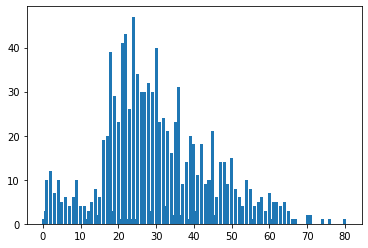

In [100]:
bars('Age')

In [103]:
title = df_object['Title'].reset_index().drop('index', axis=1)

In [108]:
df_numeric_adj = pd.concat([df_numeric.reset_index().drop('index', axis=1), title], axis=1)

In [119]:
df_numeric_adj['Age'].fillna(value=df_numeric_adj.groupby('Title')['Age'].transform('mean'), inplace=True)

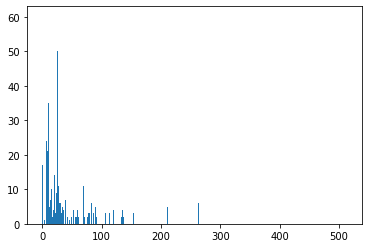

In [123]:
bars('Fare')

In [122]:
df_numeric_adj['Fare'].mean()

33.29547928134557

In [124]:
df_numeric_adj['Fare'].fillna(df_numeric_adj['Fare'].mean(), inplace=True)

In [127]:
df_numeric_adj.drop('Title', axis=1, inplace=True)

In [128]:
df_numeric_adj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 5 columns):
Pclass    1309 non-null int64
Age       1309 non-null float64
SibSp     1309 non-null int64
Parch     1309 non-null int64
Fare      1309 non-null float64
dtypes: float64(2), int64(3)
memory usage: 51.2 KB


# Combine

In [132]:
df_all = pd.concat([df_object_adj, df_numeric_adj], axis=1)

In [133]:
df_all.head()

,Family_Name,Ticket_Pre,Ticket_Num,Title_Col.,Title_Dr.,Title_Else,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,...,Cabin_Pre_N,Cabin_Pre_T,Embarked_C,Embarked_Q,Embarked_S,Pclass,Age,SibSp,Parch,Fare
0,100,5,210,0,0,0,0,0,1,0,...,1,0,0,0,1,3,22.0,1,0,7.2500
1,182,22,166,0,0,0,0,0,0,1,...,0,0,1,0,0,1,38.0,1,0,71.2833
2,329,43,461,0,0,0,0,1,0,0,...,1,0,0,0,1,3,26.0,0,0,7.9250
3,267,20,67,0,0,0,0,0,0,1,...,0,0,0,0,1,1,35.0,1,0,53.1000
4,15,20,819,0,0,0,0,0,1,0,...,1,0,0,0,1,3,35.0,0,0,8.0500


In [134]:
df_all.shape

(1309, 31)

# Evaluation

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# 將前述轉換完畢資料 df , 重新切成 train_X, test_X, 因為不論何種特徵工程, 都需要對 train / test 做同樣處理
# 常見並簡便的方式就是 - 先將 train / test 接起來, 做完後再拆開, 不然過程當中往往需要將特徵工程部分寫兩次, 麻煩且容易遺漏
# 在較複雜的特徵工程中尤其如此, 若實務上如果碰到 train 與 test 需要分階段進行, 則通常會另外寫成函數處理
train_X = df_all[:train_num]
test_X = df_all[train_num:]

In [146]:
# 使用線性迴歸模型 : train_X, train_Y 訓練模型, 並對 test_X 做出預測結果 pred
estimator = LogisticRegression()
estimator.fit(train_X, train_Y)
pred_log = estimator.predict(test_X)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [179]:
print(estimator.score(train_X, train_Y))

0.9988776655443322


In [147]:
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}')

score : 0.8238701362904362


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

In [178]:
pd.DataFrame({'PassengerId':ids, 'Survived':pred_log}).to_csv('tatanic_log1.csv', index=False)

In [180]:
df_short = df_all.drop(['Family_Name', 'Ticket_Num'], axis=1)
train_X = df_short[:train_num]
test_X = df_short[train_num:]
estimator = LogisticRegression()
estimator.fit(train_X, train_Y)
pred_log = estimator.predict(test_X)
print(estimator.score(train_X, train_Y))
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}')

0.8361391694725028
score : 0.8249431606004283


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

In [181]:
pd.DataFrame({'PassengerId':ids, 'Survived':pred_log}).to_csv('tatanic_log2.csv', index=False)

In [153]:
clf = DecisionTreeClassifier()
clf.fit(train_X, train_Y)
pred_clf = estimator.predict(test_X)
print(f'score : {cross_val_score(clf, train_X, train_Y, cv=5).mean()}')

score : 0.785553554222358


In [161]:
pd.DataFrame(ids)

,PassengerId
0,892
1,893
2,894
3,895
4,896
5,897
6,898
7,899
8,900
9,901


In [162]:
ids

0       892
1       893
2       894
3       895
4       896
5       897
6       898
7       899
8       900
9       901
10      902
11      903
12      904
13      905
14      906
15      907
16      908
17      909
18      910
19      911
20      912
21      913
22      914
23      915
24      916
25      917
26      918
27      919
28      920
29      921
       ... 
388    1280
389    1281
390    1282
391    1283
392    1284
393    1285
394    1286
395    1287
396    1288
397    1289
398    1290
399    1291
400    1292
401    1293
402    1294
403    1295
404    1296
405    1297
406    1298
407    1299
408    1300
409    1301
410    1302
411    1303
412    1304
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [158]:
df_all.columns

Index(['Family_Name', 'Ticket_Pre', 'Ticket_Num', 'Title_Col.', 'Title_Dr.',
       'Title_Else', 'Title_Master.', 'Title_Miss.', 'Title_Mr.', 'Title_Mrs.',
       'Title_Ms.', 'Title_Rev.', 'Sex_female', 'Sex_male', 'Cabin_Pre_A',
       'Cabin_Pre_B', 'Cabin_Pre_C', 'Cabin_Pre_D', 'Cabin_Pre_E',
       'Cabin_Pre_F', 'Cabin_Pre_G', 'Cabin_Pre_N', 'Cabin_Pre_T',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass', 'Age', 'SibSp',
       'Parch', 'Fare'],
      dtype='object')

In [155]:
estimator.feature_importances_

array([0.15977497, 0.01948463, 0.1440034 , 0.        , 0.        ,
       0.        , 0.        , 0.00237838, 0.30233711, 0.00305792,
       0.        , 0.02283993, 0.01041156, 0.        , 0.00398083,
       0.        , 0.00856216, 0.01034091, 0.00934762, 0.        ,
       0.        , 0.        , 0.        , 0.00550381, 0.00303494,
       0.00396396, 0.07259809, 0.08525782, 0.00899254, 0.01108569,
       0.11304374])

In [142]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

0       892
1       893
2       894
3       895
4       896
5       897
6       898
7       899
8       900
9       901
10      902
11      903
12      904
13      905
14      906
15      907
16      908
17      909
18      910
19      911
20      912
21      913
22      914
23      915
24      916
25      917
26      918
27      919
28      920
29      921
       ... 
388    1280
389    1281
390    1282
391    1283
392    1284
393    1285
394    1286
395    1287
396    1288
397    1289
398    1290
399    1291
400    1292
401    1293
402    1294
403    1295
404    1296
405    1297
406    1298
407    1299
408    1300
409    1301
410    1302
411    1303
412    1304
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64